##Assignment 3.2 - Autoencoders and Stacked Autoencoders

In this file, we will implement two network architectures from scrath: (1) Autoencoders; (2) Stacked Autoencoders.

We will train both networks on the MNIST dataset under reconstruction learning task. All training will be conducted on a single T4 GPU.


In [67]:
# Please first load your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Please go to the folder with all assignment files
# Please change the following path to your own path
!cd /content/drive/MyDrive/DataMiningAndNeuralNetworks/session3/

In [69]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi

Fri Jan  5 00:13:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |    171MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Autoencoder
In this section, we implement Linear Autoencoder from scratch and training it on the MNIST dataset. With this autoencoder, we pass input data through an encoder making a compressed representation of the input, and then pass this representation to the following decoder to build the reconstruction data.
Codes will be implemeneted with ``PyTorch``.


In [70]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [71]:
## Create training and test dataloaders

# How many samples per batch to load
# You can tune the batch size
batch_size = 20

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle = True,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle = False,
                                          num_workers=0)

## Visualize the data

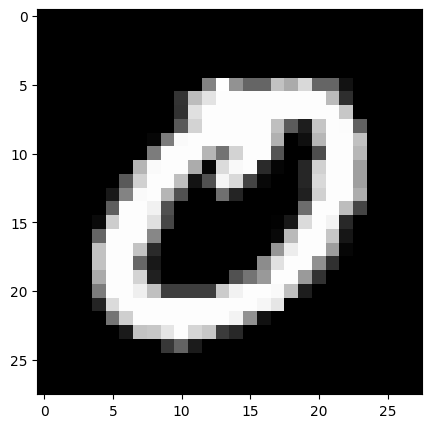

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Build the Linear Autoencoder
We now train a linear autoencoder on MINIST dataset.
Images of original size 28$\times$28 will be flattened into 784-dimensional vectors.
Note that images from this dataset are already normalized so that the values are between 0 and 1.
Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

The encoder and decoder in the Autoencoder are built with one linear layer where you can tune the dimension of the hidden representation, i.e., ``encoding_dim``, to obtain models with different size.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

# Define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(784, encoding_dim)
        # Decoder
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        # Define feedforward behavior
        # and scale the *output* layer with a sigmoid activation function

        # Pass x into encoder
        out = F.relu(self.encoder(x))
        # Pass out into decoder
        out = torch.sigmoid(self.decoder(out))

        return out

In [74]:
# Initialize the NN
# You can change the encoding_dim to obtain models with different size
encoding_dim = 128
model = Autoencoder(encoding_dim)

# Send model to GPU
model.cuda()
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=784, bias=True)
)


## Training on MNIST
Since we work on reconstruction learning tasks, we do not need the labels here but only the images.
The loss function should choose the MSE loss for reconstruction.

In [75]:
# Specify the loss function
criterion = nn.MSELoss()

# We use Adam as the optimizer with a fixed learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [77]:
# Number of epochs to train the model
# You can also tune the number of Epochs
n_epochs = 50
# Set model to training mode
model.train()

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Train the model #

    for data in train_loader:
        # _ stands in for labels
        # we do not need labels when conducting reconstruction
        images, _ = data
        # Flatten images and send images to GPU
        images = images.view(images.size(0), -1).cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, images)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*images.size(0)

    # Print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 0 	Training Loss: 0.032855
Epoch: 1 	Training Loss: 0.032862
Epoch: 2 	Training Loss: 0.032860
Epoch: 3 	Training Loss: 0.032815
Epoch: 4 	Training Loss: 0.032803
Epoch: 5 	Training Loss: 0.032784
Epoch: 6 	Training Loss: 0.032758
Epoch: 7 	Training Loss: 0.032773
Epoch: 8 	Training Loss: 0.032741
Epoch: 9 	Training Loss: 0.032744
Epoch: 10 	Training Loss: 0.032718
Epoch: 11 	Training Loss: 0.032714
Epoch: 12 	Training Loss: 0.032702
Epoch: 13 	Training Loss: 0.032653
Epoch: 14 	Training Loss: 0.032705
Epoch: 15 	Training Loss: 0.032711
Epoch: 16 	Training Loss: 0.032667
Epoch: 17 	Training Loss: 0.032660
Epoch: 18 	Training Loss: 0.032651
Epoch: 19 	Training Loss: 0.032642
Epoch: 20 	Training Loss: 0.032650
Epoch: 21 	Training Loss: 0.032603
Epoch: 22 	Training Loss: 0.032611
Epoch: 23 	Training Loss: 0.032580
Epoch: 24 	Training Loss: 0.032602
Epoch: 25 	Training Loss: 0.032585
Epoch: 26 	Training Loss: 0.032563
Epoch: 27 	Training Loss: 0.032587
Epoch: 28 	Training Loss: 0.03

## Evaluation on test set
We now evaluate the reconstruction results on the test set.
We plot the original test images and their corresponding reconstruction ones.

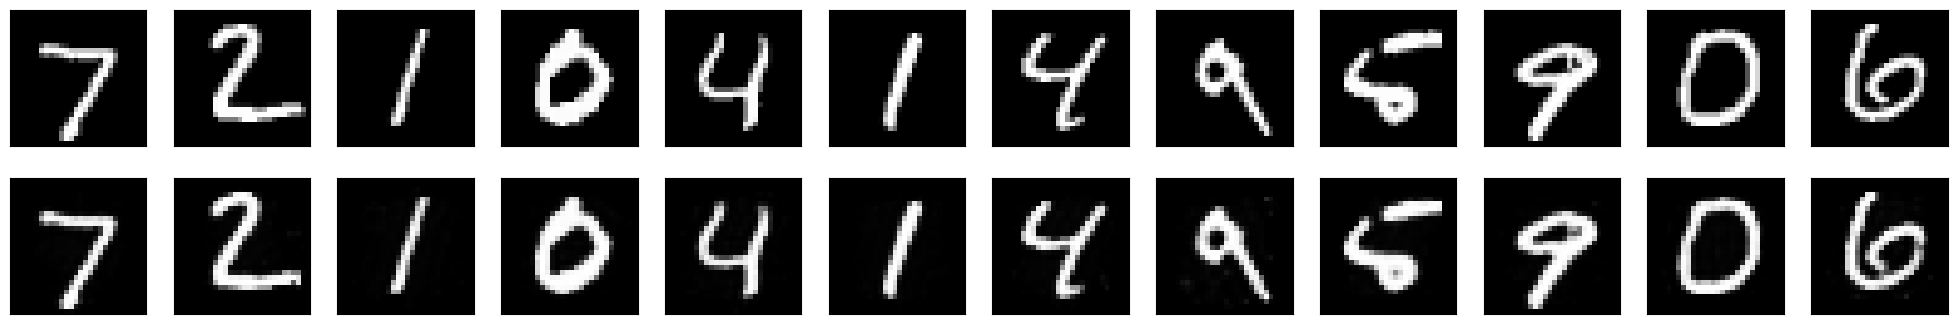

In [81]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1)
# Set model to evaluation mode
model.eval()
# Send model back to CPU
model.cpu()
# Get sample outputs
output = model(images_flatten)
# Prep images for display
images = images.numpy()

# Output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=12, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Stacked Autoencoder
In this section, we implement the Stacked Autoencoder from scrath and train it on the MNIST dataset.
The training process is with two steps: (1) each layer is trained separately; (2) the network is trained as a whole.

We first load the dataset as follows:

In [82]:
import torch
from torch import nn, optim, functional, utils
from torch.nn import BCELoss
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

def get_mnist_loader(batch_size=100, shuffle=True):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_loader, test_loader

## Build the Stacked Autoencoder
Before building the Stacked Autoencoder, we need to build the Autoencoder layer first.

In [83]:
class AutoEncoderLayer(nn.Module):
    """
    fully-connected linear layers for stacked autoencoders.
    This module can automatically be trained when training each layer is enabled
    Yes, this is much like the simplest auto-encoder
    """
    def __init__(self, input_dim=None, output_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()
        # If input_dim is None or output_dim is None:
        # raise ValueError
        self.in_features = input_dim
        self.out_features = output_dim
        # Whether to conduct layer-by-layer pre-training, or train the entire network
        self.is_training_self = SelfTraining
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.Sigmoid()  # use Sigmoid activation function
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.encoder(x)
        if self.is_training_self:
            return self.decoder(out)
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other


class StackedAutoEncoder(nn.Module):
    """
    Construct the whole network with layers_list
    Stacked autoencoders is generally symmetrical about the middle hidden layer
    """
    def __init__(self, layers_list=None):
        super(StackedAutoEncoder, self).__init__()
        self.layers_list = layers_list
        self.initialize()
        self.encoder_1 = self.layers_list[0]
        self.encoder_2 = self.layers_list[1]
        self.encoder_3 = self.layers_list[2]
        self.encoder_4 = self.layers_list[3]

    def initialize(self):
        for layer in self.layers_list:
            # assert isinstance(layer, AutoEncoderLayer)
            layer.is_training_layer = False

    def forward(self, x):
        out = x
        out = self.encoder_1(out)
        out = self.encoder_2(out)
        out = self.encoder_3(out)
        out = self.encoder_4(out)
        return out

## The training function of each layer
We need to freeze the parameters in the previsou layers when training the current layer.

In [84]:
def train_layers(layers_list=None, layer=None, epoch=None, validate=True):
    """
    Greedy layer-wise training: when training the i-th layer, freeze the i-1 layer
    :param layers_list:
    :param layer:
    :param epoch:
    :return:
    """
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(layers_list[layer].parameters(), lr=0.001)
    criterion = BCELoss()

    # Train
    for epoch_index in range(epoch):
        sum_loss = 0.

        # Freeze the parameters of all layers before the current layer
        # Layer 0 has no previous layer
        if layer != 0:
            for index in range(layer):
                # In addition to freezing parameters
                # the output return method of the frozen layer must also be set.
                layers_list[index].lock_grad()
                layers_list[index].is_training_layer = False

        for batch_index, (train_data, _) in enumerate(train_loader):
            # Generate input data
            if torch.cuda.is_available():
                train_data = train_data.cuda()  # Put data onto GPU
            out = train_data.view(train_data.size(0), -1)

            # Perform forward calculation on the frozen layers before (layer-1)-th layer
            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            # Train the layer-th layer
            pred = layers_list[layer](out)

            optimizer.zero_grad()
            loss = criterion(pred, out)
            sum_loss += loss
            loss.backward()
            optimizer.step()
            if (batch_index + 1) % 10 == 0:
                print("Train Layer: {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(
                    layer, (epoch_index + 1), epoch, (batch_index + 1), len(train_loader), loss
                ))

        if validate:
            pass

## The training function of the whole network
Now we unfreeze all the parameters in the network that are previously frozen for the layer training.

In [86]:
def train_whole(model=None, epoch=50, validate=True):

    print(">> start training whole model")
    if torch.cuda.is_available():
        model.cuda()

    # unfreeze the parameters frozen in pre-training
    for param in model.parameters():
        param.require_grad = True

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size, shuffle=shuffle)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    # Generate/save the original test image --take a batch_size
    test_data, _ = next(iter(test_loader))
    torchvision.utils.save_image(test_data, './test_images/real_test_images.png')

    model.train()

    # train
    for epoch_index in range(epoch):
        sum_loss = 0.
        for batch_index, (train_data, _) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data = train_data.cuda()
            x = train_data.view(train_data.size(0), -1)

            out = model(x)

            optimizer.zero_grad()
            loss = criterion(out, x)
            sum_loss += loss
            loss.backward()
            optimizer.step()

            if (batch_index + 1) % 10 == 0:
                print("Train Whole, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(
                    (epoch_index + 1), epoch, (batch_index + 1), len(train_loader), loss
                ))
            if batch_index == len(train_loader) - 1:
                torchvision.utils.save_image(out.view(100, 1, 28, 28), "./test_images/out_{}_{}.png".format(epoch_index, batch_index))

        # evaluate the model for each epoch
        if validate:
            with torch.no_grad():
                model.eval()
                if torch.cuda.is_available():
                    test_data = test_data.cuda()
                x = test_data.view(test_data.size(0), -1)
                out = model(x)
                loss = criterion(out, x)
                print("Test Epoch: {}/{}, Iter: {}/{}, test Loss: {}".format(
                    epoch_index + 1, epoch, (epoch_index + 1), len(test_loader), loss
                ))
                image_tensor = out.view(batch_size, 1, 28, 28)
                torchvision.utils.save_image(image_tensor, './test_images/test_image_epoch_{}.png'.format(epoch_index))

    print("<< end training whole model")


## Let's start training!
The default network is trained with layer epochs 20, whole epochs 50, batch size of 100. You can try to change the hyper-parameters to obtain better reconstruction performance.

In [87]:
# You can change the hyper-parameters here
num_tranin_layer_epochs = 20
num_tranin_whole_epochs = 50
batch_size = 100
shuffle = True

In [88]:
import os
if not os.path.exists('test_images'):
    os.mkdir('test_images')
if not os.path.exists('models'):
    os.mkdir('models')

nun_layers = 5
encoder_1 = AutoEncoderLayer(784, 256, SelfTraining=True)
encoder_2 = AutoEncoderLayer(256, 64, SelfTraining=True)
decoder_3 = AutoEncoderLayer(64, 256, SelfTraining=True)
decoder_4 = AutoEncoderLayer(256, 784, SelfTraining=True)
layers_list = [encoder_1, encoder_2, decoder_3, decoder_4]

# Pre-train each layer
for level in range(nun_layers - 1):
    train_layers(layers_list=layers_list, layer=level, epoch=num_tranin_layer_epochs, validate=True)

# Training the network as a whole
SAE_model = StackedAutoEncoder(layers_list=layers_list)
train_whole(model=SAE_model, epoch=num_tranin_whole_epochs, validate=True)

# Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)
torch.save(SAE_model, './models/sae_model.pt')

100%|██████████| 9912422/9912422 [00:00<00:00, 241317990.11it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40324798.21it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7757972.80it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19399723.80it/s]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Train Layer: 2, Epoch: 8/20, Iter: 330/600, Loss: 0.5955
Train Layer: 2, Epoch: 8/20, Iter: 340/600, Loss: 0.5951
Train Layer: 2, Epoch: 8/20, Iter: 350/600, Loss: 0.5935
Train Layer: 2, Epoch: 8/20, Iter: 360/600, Loss: 0.5949
Train Layer: 2, Epoch: 8/20, Iter: 370/600, Loss: 0.5950
Train Layer: 2, Epoch: 8/20, Iter: 380/600, Loss: 0.5952
Train Layer: 2, Epoch: 8/20, Iter: 390/600, Loss: 0.5944
Train Layer: 2, Epoch: 8/20, Iter: 400/600, Loss: 0.5941
Train Layer: 2, Epoch: 8/20, Iter: 410/600, Loss: 0.5957
Train Layer: 2, Epoch: 8/20, Iter: 420/600, Loss: 0.5932
Train Layer: 2, Epoch: 8/20, Iter: 430/600, Loss: 0.5944
Train Layer: 2, Epoch: 8/20, Iter: 440/600, Loss: 0.5967
Train Layer: 2, Epoch: 8/20, Iter: 450/600, Loss: 0.5956
Train Layer: 2, Epoch: 8/20, Iter: 460/600, Loss: 0.5970
Train Layer: 2, Epoch: 8/20, Iter: 470/600, Loss: 0.5930
Train Layer: 2, Epoch: 8/20, Iter: 480/600, Loss: 0.5950
Train Laye

In [115]:
# You can later check the saved test images here
!cd /root/test_images
!ls

/bin/bash: line 1: cd: /root/test_images: No such file or directory
data  drive  models  sample_data  test_images
